<a href="https://colab.research.google.com/github/pasquale90/mthesis/blob/master/DenseNet/esc_3.mel%5Bnew_features%2BDenseNet_121%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Google_drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip uninstall librosa
!pip install librosa

In [2]:
#Import libraries
import os
import pandas as pd
import librosa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import math
from torch.autograd import Variable
from torchvision import transforms, models


data_path='/content/gdrive/My Drive/dissertation/ESC-50-master/meta/esc50.csv'
audio_path='/content/gdrive/My Drive/dissertation/ESC-50-master/audio/'

In [3]:
mode = 'exp3_1'
#mode = 128

In [4]:
#Import Dataset
esc50 = pd.read_csv(data_path)
audiofiles = os.listdir(audio_path)
print(esc50.shape)
print(len(audiofiles))

(2000, 7)
2000


In [5]:
#store_sorted_class_names, in the same way that are returned from dataset_class in data.py
esc_classes = sorted(esc50['category'].unique())
num_classes = len(esc_classes)
print(num_classes)

50


In [6]:
folds = sorted(esc50['fold'].unique())
print(folds)

[1, 2, 3, 4, 5]


In [7]:
if mode==80:
  feature_path = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/80/'
elif mode==128:
  feature_path = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/128/'
elif mode == 'exp3_1':
   feature_path = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/dense121/mel/360/'
print(feature_path)

/content/gdrive/My Drive/dissertation/ESC-50-master/features/dense121/mel/360/


In [13]:
#train and fold definition
vfold=5 #3,2,1||5
train_folds = esc50[esc50['fold']!=vfold]
valid_folds = esc50[esc50['fold']==vfold]
print(train_folds)
print(valid_folds)

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1595    4-99193-B-4.wav     4       4            frog  False     99193    B
1596    4-99644-A-4.wav     4       4            frog  False     99644    A
1597    4-99644-B-4.wav     4       4            frog  False     99644    B
1598    4-99644-C-4.wav     4       4            frog  False     99644    C
1599    4-99644-D-4.wav     4       4            frog  False     99644    D

[1600 rows x 7 columns]
               filename  fold  target        category  esc10  s

In [14]:
if mode == 80:#80x79
  sr=16000
  hop_length=1024
  n_fft=1024
  n_mels=mode
elif mode==128:#128x157
  sr=16000
  hop_length=512
  n_fft=512
  n_mels=mode
elif mode == 'exp3_1':#...
  sr=44100
  hop_length=512
  n_fft=2048
  n_mels = 360
print(sr,hop_length,n_fft,n_mels)

44100 512 2048 360


Απ όσα διάβασα τo DenseNet δέχεται εικόνες διαστάσεων 224 οπότε και επέλεξα n_mels=360(image's axis=0) ούτως ώστε να συμβαδίζει με τις απαιτήσεις του δικτύου.

In [ ]:
#@title extract_spectograms
def extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft, n_mels):#df
  '''
  def _windows(data, window_size,overlap):
    start = 0
    while start < len(data):
      yield start, start + window_size
      start += (window_size-overlap)
  
  def _segments(data, segment_length):
    start = 0
    while start < len(data):
      yield start, start + segment_length
      start += segment_length
  
  def zero_pad_to_closest(signal,sr, overlap):
    num_zeros=overlap - (len(signal)-(len(signal)//overlap)*overlap)
    zp=np.zeros(num_zeros,dtype=float)
    padded_signal = np.concatenate((signal,zp),axis=0)
    return padded_signal
  '''
  def normalize(spec,eps=1e-6):
    min = spec.min()
    max = spec.max()
    norm_spec = (2*(spec-min)/((max-min)+eps))-1
    return norm_spec
  
  def convert2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

  def plot_image(spectogram):
    img = plt.imshow(spectogram)
    plt.axis('off')
    plt.show()

  window_size = sr#//2#half second
  overlap =int(window_size*0.75)#//2)#//2#*0.75
  #print('overlap=',overlap)
  segment_length = sr
  features, labels, folders = [], [], []
  count_segments = 0
  for file in tqdm(audiofiles):
    #label = int(df.loc[df['filename']==file]['target'].to_string(index=False))
    #folder = int(df.loc[df['filename']==file]['fold'].to_string(index=False))
    name = file.split('.wav')[0]
    label = int(file.split('-')[-1].split('.')[0])
    folder = int(file.split('-')[0])
    #print('name', name)
    #print('folder',folder)
    #print('label',label) 

    raw, fs=librosa.load(audio_path+file, sr=sr, mono=True)
    #print(f'{file} had length {len(raw)}')

    S=librosa.feature.melspectrogram(y=raw.astype(float),
                                   sr=sr,S=None,
                                   n_fft=n_fft,
                                   hop_length=hop_length, 
                                   power=2,
                                   n_mels=n_mels) 
    print(S.shape)
    S = librosa.power_to_db(S, ref=np.max)
    print(S.shape)
    #print('min',S.min())#-80.0
    #print('max', S.max())#0.0
    #S = convert_to_image(S)
    #S = normalize(S)
    #print(S.min())
    #print(S.max())
    #plot_image(S)

    #plot_image(S)
    print(S.shape)
    '''
    if (len(raw)%(window_size-overlap) != 0):
      raw = zero_pad_to_closest(raw,fs,overlap)
      print(f'now has length {len(raw)}')
    
    for (segstart,segend) in _segments(raw,segment_length):
      if len(raw[segstart:segend])==segment_length:
        segment = raw[segstart:segend]
        #print('segstart,segend',segstart,segend)
        S=librosa.feature.melspectrogram(y=segment.astype(float),
                                   sr=sr,S=None,
                                   n_fft=n_fft,
                                   win_length=window_size, 
                                   window='hann', 
                                   hop_length=(window_size-overlap), 
                                   power=2,
                                   n_mels=n_mels) 
        

        S = librosa.power_to_db(S, ref=np.max)
        S = normalize(S)

        S = S.T.flatten()[:, np.newaxis].T
        
        #print('S.shape',S.shape)
        #print('S_dtype',S.dtype)
        #print('min',S.min())
        #print('max', S.max())

        features.append(np.asarray(S,dtype=np.float16))
        labels.append(label)
        folders.append(folder)
        count_segments+=1
    '''
  '''  
  sequence_length = segment_length//(window_size-overlap)+1
  #print('sequence_length',sequence_length) 
  #print('count_segments',count_segments)
  features = np.asarray(features).reshape(count_segments,
                                          sequence_length,
                                          n_mels)
  '''                                          
  '''
  print('features.shape:',features.shape)
  print('labels',len(labels))
  print('folders',len(folders))
  '''

  '''
  print('len(features)-segments',len(features))
  print('len(features[0])-frames',len(features[0]))
  print('len(features[0][0])-frame size',len(features[0][0]))
  #print('len(features[0][0][0])',len(features[0][0][0]))
  print('labels',len(labels))
  #print('labels[]',len(labels[0]))
  print('folders',len(folders))
  #print('folders[]',len(folders[0]))

  print('type(features)-segments',type(features))
  print('type(features[0])-frames',type(features[0]))
  print('type(features[0][0])-frame size',type(features[0][0]))
  print('labels',type(labels))
  print('folders',type(folders))
  '''
  return features,labels,folders

In [34]:
#@title extract_spectograms - clean
def extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft, n_mels):
  
  def scale_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 256 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled
  def plot_image(spectogram):
    img = plt.imshow(spectogram)
    plt.axis('off')
    plt.show()
  features, labels, folders = [], [], []
  for file in tqdm (audiofiles):
    #label = int(df.loc[df['filename']==file]['target'].to_string(index=False))
    #folder = int(df.loc[df['filename']==file]['fold'].to_string(index=False))
    name = file.split('.wav')[0]
    label = int(file.split('-')[-1].split('.')[0])
    folder = int(file.split('-')[0])
    #print('name', name)
    #print('folder',folder)
    #print('label',label) 

    raw, fs=librosa.load(audio_path+file, sr=sr, mono=True)
    #print(f'{file} had length {len(raw)}')
    S=librosa.feature.melspectrogram(y=raw.astype(float),
                                   sr=sr,S=None,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   window='hann', 
                                   power=2,
                                   n_mels=n_mels) 
    S = librosa.power_to_db(S, ref=np.max)
    '''erase
    stft=librosa.core.stft(y=raw.astype(float),
                    n_fft=n_fft, 
                    hop_length=hop_length, 
                    window='hann',
                    center=True)
    magnitude = np.abs(stft)
    #to spectogram
    S = librosa.amplitude_to_db(magnitude, ref=np.max )
    '''
    #print(S.shape)

    #to gray scale
    greyscale = scale_image(S)

    #make it 3D
    image = Image.fromarray(greyscale)
    rgb = image.convert('RGB')
    
    #save image
    rgb.save(feature_path+name+'.png')
    #rgb.save('/content/test/'+name+'.png')

In [35]:
extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft, n_mels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


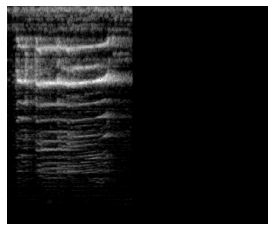

shape: (360, 431, 3)
min: 0
max: 254


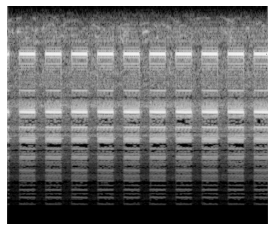

shape: (360, 431, 3)
min: 0
max: 255


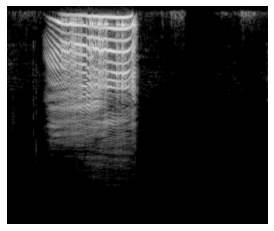

shape: (360, 431, 3)
min: 0
max: 252


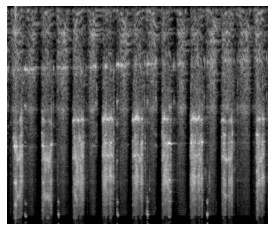

shape: (360, 431, 3)
min: 0
max: 254


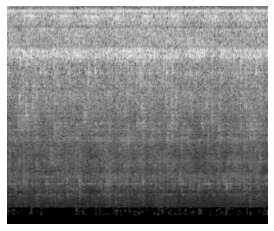

shape: (360, 431, 3)
min: 0
max: 253


In [32]:
#print a few
for feature in (os.listdir(feature_path)[0:5]):
  image = Image.open(feature_path+feature)
  plt.axis('off')
  plt.imshow(image)
  plt.show()
  feature = np.array(image)
  print('shape:',feature.shape) 
  print('min:',feature.min())
  print('max:',feature.max())

Grayscaled ούτως ώστε να εξυπηρετεί στην εξισσορόπηση των διαφορών βαθμού κβάντισης μεταξύ των datasets και 3 διαστάσεων προκειμένου να συμβαδίζει με τις προδιαγραφές των εισόδων που δέχεται το DenseNet.

In [ ]:
'''
con_files = os.listdir(audio_path)
count=0
for file in tqdm(con_files):
  if 'png' in file.split('.'):
    #print(file)
    count+=1
    #os.rename(audio_path+file,feature_path+file)
    #os.remove('/content/'+file)
print(count)
'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



2000


In [15]:
#DATA TRANSFORMS
# Data augmentation and normalization
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
valid_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [38]:
#@title THE DataClass
class Data(Dataset):
  def __init__(self, df, in_col, out_col, mode, path,transform):#(train, 'filename', 'category', mode)
    self.df = df
    self.data = []
    self.labels = []
    
    #for ind in tqdm(range(len(df))):
    for check,ind in tqdm(enumerate(range(len(df)))):
      row = df.iloc[ind]
      image = get_features(row[in_col],path)
      self.data.append(transform(image))#[np.newaxis,...])
      #self.data.append(get_features(row[in_col],path)[np.newaxis,...])
      self.labels.append(row[out_col])
      #print(f' file: {row[in_col]}, of shape: {self.data[check].shape}, has label: {self.labels[check]}, is of type{type(self.data[check])}. It also has min: {torch.min(self.data[check])} and {torch.max(self.data[check])}' )
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):#load data on demand
    return self.data[idx], self.labels[idx]

def get_features(wavname, featurepath):    
  name= featurepath + wavname.split('.')[0]+'.png'
  image=Image.open(name)
  #image=np.array(image)
  #image = image/255.0
  return image

vfold=5 #3,2,1||5
train_data = esc50[esc50['fold']!=vfold]
valid_data = esc50[esc50['fold']==vfold]

train_data = Data(train_data,  'filename', 'target', mode, feature_path,train_transforms)
valid_data = Data(valid_data,  'filename', 'target', mode, feature_path,valid_transforms)
#data iterator
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [17]:
#define device
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)

cpu


In [13]:
#@title DenseNet
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
model = model_ft.to(device)

# Print the model we just instantiated
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params} total trainable params')

7005106 total parameters.
7005106 total trainable params


In [ ]:
#@title ResNet
model = models.resnet152(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

for param in model.layer4.parameters():
  param.requires_grad = True
for param in model.avgpool.parameters():
  param.requires_grad = True
for param in model.fc.parameters():
  param.requires_grad = True

model.fc = nn.Linear(2048,num_classes)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params} total trainable params')

In [40]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5#1#1e-3,
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-6)
#learning_rate = 1.0
#optimizer = optim.Adadelta(model.parameters(), learning_rate)
epochs = 30
train_losses = []
valid_losses = []

#optimizer
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

def train(model, loss_fn, train_loader, valid_loader,
          epochs, optimizer, train_losses, valid_losses, change_lr):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()#set the model to training mode
    batch_losses=[]
    #if change_lr:
     # optimizer = change_lr(optimizer, epoch)
    for i, data in tqdm(enumerate(train_loader)):#performs a step in the train loop 
      x, y = data     
      optimizer.zero_grad()#zero the gradients before updating them
      x = x.to(device, dtype=torch.float32) #init tensor _minibatch(16) of spectograms
      y = y.to(device, dtype=torch.long)  #init tensor _categories' id
      y_hat = model(x) #the equation is the model itself-,model is actually a modeled equation
      loss = loss_fn(y_hat, y)#compute forward loss
      loss.backward() #for alleviating the parameters' loss
      batch_losses.append(loss.item()) #here batch_calc is returned
      optimizer.step()#step of the optimizer-updates the parameters/  batch?mini-batch?stohastic? 
      #print(model.state_dict())
    train_losses.append(batch_losses)

    print()
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    print()
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    #print('debug')
    for i, data in enumerate(valid_loader):
      x, y = data
      #print('x,y')
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      #print('yhat')
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())#allocate the tensor in RAM 
                                  #detatch --> cut computational graph
                                  #cpu --> allocate tensor in RAM
                                  #numpy --> port tensor to numpy
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)#mean of Trues
    
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(params)
    #micro,macro auroc
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy} ')

  #return train_losses,valid_losses,accuracy,trace_y,trace_yhat,batch_losses

In [ ]:
#resnet model
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.8284199833869934

15067186
Epoch - 1 Valid-Loss : 3.565278797149658 Valid-Accuracy : 0.1275 




Epoch - 2 Train-Loss : 3.308594515323639

15067186
Epoch - 2 Valid-Loss : 3.1962447452545164 Valid-Accuracy : 0.305 




Epoch - 3 Train-Loss : 2.8811228275299072

15067186
Epoch - 3 Valid-Loss : 2.8736053466796876 Valid-Accuracy : 0.38 




Epoch - 4 Train-Loss : 2.4887361240386965

15067186
Epoch - 4 Valid-Loss : 2.613721227645874 Valid-Accuracy : 0.4125 




Epoch - 5 Train-Loss : 2.130561298131943

15067186
Epoch - 5 Valid-Loss : 2.4204884243011473 Valid-Accuracy : 0.45 




Epoch - 6 Train-Loss : 1.8038950777053833

15067186
Epoch - 6 Valid-Loss : 2.2809993028640747 Valid-Accuracy : 0.4825 




Epoch - 7 Train-Loss : 1.5076954412460326

15067186
Epoch - 7 Valid-Loss : 2.179153127670288 Valid-Accuracy : 0.5025 




Epoch - 8 Train-Loss : 1.2421316623687744

15067186
Epoch - 8 Valid-Loss : 2.1023605966567995 Valid-Accuracy : 0.51 




Epoch - 9 Train-Loss : 1.0082318419218064

15067186
Epoch - 9 Valid-Loss : 2.044619641304016 Valid-Accuracy : 0.515 




Epoch - 10 Train-Loss : 0.8072086679935455

15067186
Epoch - 10 Valid-Loss : 1.999818000793457 Valid-Accuracy : 0.515 




Epoch - 11 Train-Loss : 0.6394800126552582

15067186
Epoch - 11 Valid-Loss : 1.9663892698287964 Valid-Accuracy : 0.52 




Epoch - 12 Train-Loss : 0.5036069628596306

15067186
Epoch - 12 Valid-Loss : 1.9371286487579347 Valid-Accuracy : 0.5175 




Epoch - 13 Train-Loss : 0.39638346642255784

15067186
Epoch - 13 Valid-Loss : 1.9105653476715088 Valid-Accuracy : 0.525 




Epoch - 14 Train-Loss : 0.31370332807302476

15067186
Epoch - 14 Valid-Loss : 1.8902611827850342 Valid-Accuracy : 0.525 




Epoch - 15 Train-Loss : 0.2510602329671383

15067186
Epoch - 15 Valid-Loss : 1.8803826904296874 Valid-Accuracy : 0.5225 




Epoch - 16 Train-Loss : 0.20390017338097097

15067186
Epoch - 16 Valid-Loss : 1.8772882413864136 Valid-Accuracy : 0.52 


KeyboardInterrupt: ignored

In [ ]:
#DenseNet 360 adadelta 1.0
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 4.219812724590302

7005106
Epoch - 1 Valid-Loss : 37.73856442451477 Valid-Accuracy : 0.0425 




Epoch - 2 Train-Loss : 3.7425203943252563

7005106
Epoch - 2 Valid-Loss : 3.391128273010254 Valid-Accuracy : 0.07 




Epoch - 3 Train-Loss : 3.473802843093872

7005106
Epoch - 3 Valid-Loss : 120.53101547241211 Valid-Accuracy : 0.0875 




Epoch - 4 Train-Loss : 3.297655997276306

7005106
Epoch - 4 Valid-Loss : 3.243231010437012 Valid-Accuracy : 0.1725 




Epoch - 5 Train-Loss : 3.147041018009186

7005106
Epoch - 5 Valid-Loss : 4.0867671775817875 Valid-Accuracy : 0.205 




Epoch - 6 Train-Loss : 3.0061218214035033

7005106
Epoch - 6 Valid-Loss : 3.8073081302642824 Valid-Accuracy : 0.1825 




Epoch - 7 Train-Loss : 2.822024505138397

7005106
Epoch - 7 Valid-Loss : 4.973393688201904 Valid-Accuracy : 0.1775 




Epoch - 8 Train-Loss : 2.662862241268158

7005106
Epoch - 8 Valid-Loss : 5.439674615859985 Valid-Accuracy : 0.205 




Epoch - 9 Train-Loss : 2.4420506238937376

7005106
Epoch - 9 Valid-Loss : 3.7941337203979493 Valid-Accuracy : 0.2275 


In [ ]:
#DenseNet 360 adam 2e-5
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.927325747013092

7005106
Epoch - 1 Valid-Loss : 3.708645753860474 Valid-Accuracy : 0.085 




Epoch - 2 Train-Loss : 3.4349873757362364

7005106
Epoch - 2 Valid-Loss : 3.4663422775268553 Valid-Accuracy : 0.185 




Epoch - 3 Train-Loss : 3.031178162097931

7005106
Epoch - 3 Valid-Loss : 3.258258171081543 Valid-Accuracy : 0.28 




Epoch - 4 Train-Loss : 2.6888673305511475

7005106
Epoch - 4 Valid-Loss : 3.0802472686767577 Valid-Accuracy : 0.3175 




Epoch - 5 Train-Loss : 2.410429792404175

7005106
Epoch - 5 Valid-Loss : 2.9311073303222654 Valid-Accuracy : 0.34 




Epoch - 6 Train-Loss : 2.194713249206543

7005106
Epoch - 6 Valid-Loss : 2.8080465602874756 Valid-Accuracy : 0.3925 




Epoch - 7 Train-Loss : 1.9884885108470918

7005106
Epoch - 7 Valid-Loss : 2.709093675613403 Valid-Accuracy : 0.405 




Epoch - 8 Train-Loss : 1.7892549860477447

7005106
Epoch - 8 Valid-Loss : 2.6158118438720703 Valid-Accuracy : 0.445 




Epoch - 9 Train-Loss : 1.6103654491901398

7005106
Epoch - 9 Valid-Loss : 2.542671494483948 Valid-Accuracy : 0.445 




Epoch - 10 Train-Loss : 1.4459626793861389

7005106
Epoch - 10 Valid-Loss : 2.470454511642456 Valid-Accuracy : 0.455 




Epoch - 11 Train-Loss : 1.2888984328508377

7005106
Epoch - 11 Valid-Loss : 2.3871310424804686 Valid-Accuracy : 0.4775 




Epoch - 12 Train-Loss : 1.1641842925548553

7005106
Epoch - 12 Valid-Loss : 2.310721673965454 Valid-Accuracy : 0.4825 




Epoch - 13 Train-Loss : 1.0727259010076522

7005106
Epoch - 13 Valid-Loss : 2.260987958908081 Valid-Accuracy : 0.485 




Epoch - 14 Train-Loss : 0.9673504596948623

7005106
Epoch - 14 Valid-Loss : 2.2311065673828123 Valid-Accuracy : 0.495 




Epoch - 15 Train-Loss : 0.857305977344513

7005106
Epoch - 15 Valid-Loss : 2.194617590904236 Valid-Accuracy : 0.5 




Epoch - 16 Train-Loss : 0.7586653727293015

7005106
Epoch - 16 Valid-Loss : 2.176274199485779 Valid-Accuracy : 0.5 




Epoch - 17 Train-Loss : 0.6732137015461922

7005106
Epoch - 17 Valid-Loss : 2.149929404258728 Valid-Accuracy : 0.5075 




Epoch - 18 Train-Loss : 0.5965031999349594

7005106
Epoch - 18 Valid-Loss : 2.1097332048416138 Valid-Accuracy : 0.51 




Epoch - 19 Train-Loss : 0.5282818311452866

7005106
Epoch - 19 Valid-Loss : 2.0747675704956055 Valid-Accuracy : 0.5275 




Epoch - 20 Train-Loss : 0.46598450154066084

7005106
Epoch - 20 Valid-Loss : 2.052062501907349 Valid-Accuracy : 0.5225 




Epoch - 21 Train-Loss : 0.41387480720877645

7005106
Epoch - 21 Valid-Loss : 2.0368860960006714 Valid-Accuracy : 0.51 




Epoch - 22 Train-Loss : 0.36848910436034205

7005106
Epoch - 22 Valid-Loss : 2.014861946105957 Valid-Accuracy : 0.5075 




Epoch - 23 Train-Loss : 0.32499799206852914

7005106
Epoch - 23 Valid-Loss : 1.997908229827881 Valid-Accuracy : 0.5025 




Epoch - 24 Train-Loss : 0.2919540949165821

7005106
Epoch - 24 Valid-Loss : 1.982801308631897 Valid-Accuracy : 0.5075 




Epoch - 25 Train-Loss : 0.2607597716152668

7005106
Epoch - 25 Valid-Loss : 1.9620337247848512 Valid-Accuracy : 0.5225 




Epoch - 26 Train-Loss : 0.2349272383749485

7005106
Epoch - 26 Valid-Loss : 1.9408476257324219 Valid-Accuracy : 0.5275 




Epoch - 27 Train-Loss : 0.21146147914230823

7005106
Epoch - 27 Valid-Loss : 1.9300099658966063 Valid-Accuracy : 0.5025 




Epoch - 28 Train-Loss : 0.1892488794773817

7005106
Epoch - 28 Valid-Loss : 1.9474937152862548 Valid-Accuracy : 0.5075 


KeyboardInterrupt: ignored

In [ ]:
Υποσειμέιωση:Στα modes 80 και 128 οι παράμετροι εξαγωγής και οι διαστάσεις των εικόνων αναφέρονται στο έγγραφο της Διπλωματικής. Κάθε εικόνα εμπεριέχει την φασματική απόκριση του εκάστοτε ηχητικού αρχείου για την καθολική διάρκεια του. 

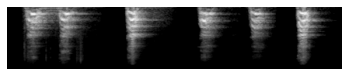

shape: (80, 431)
min: 0
max: 255


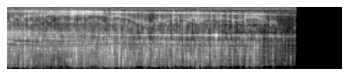

shape: (80, 431)
min: 0
max: 255


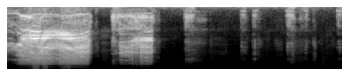

shape: (80, 431)
min: 0
max: 255


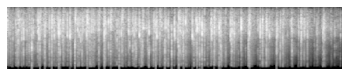

shape: (80, 431)
min: 0
max: 255


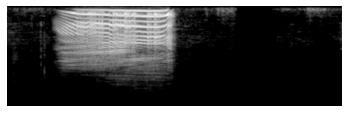

shape: (128, 431)
min: 0
max: 254


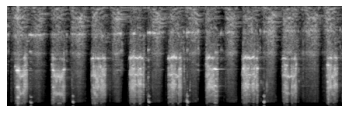

shape: (128, 431)
min: 0
max: 255


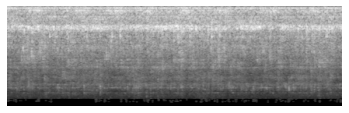

shape: (128, 431)
min: 0
max: 255


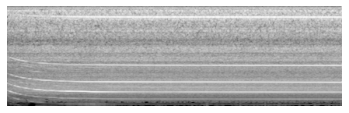

shape: (128, 431)
min: 0
max: 255


In [31]:
#previous features
old_featurepath80 = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/80/'
old_featurepath128 = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/128/'

for feature in (os.listdir(old_featurepath80)[0:4]):
  image = Image.open(old_featurepath80+feature)
  plt.axis('off')
  plt.imshow(image,cmap='gray')
  plt.show()
  feature = np.array(image)
  print('shape:',feature.shape) 
  print('min:',feature.min())
  print('max:',feature.max())

for feature in (os.listdir(old_featurepath128)[0:4]):
  image = Image.open(old_featurepath128+feature)
  plt.axis('off')
  plt.imshow(image,cmap='gray')
  plt.show()
  feature = np.array(image)
  print('shape:',feature.shape) 
  print('min:',feature.min())
  print('max:',feature.max())